# COVID-19 analysis

data source: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-01-2021.csv

In [3]:
!curl -o covid_03-01-2021.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-01-2021.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  559k    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 66  559k   66  371k    0     0   245k      0  0:00:02  0:00:01  0:00:01  245k
100  559k  100  559k    0     0   359k      0  0:00:01  0:00:01 --:--:--  360k


In [4]:
!hdfs dfs -mkdir /data/covid

mkdir: `hdfs://localhost:9000/data': No such file or directory


In [5]:
!hdfs dfs -mkdir -p /covid

In [6]:
!hdfs dfs -put -f covid_03-01-2021.csv /covid/

By adding -f, tell HDFS:

“If the file already exists, overwrite it.”

In [9]:
!hdfs dfs -ls /

Found 2 items
drwxr-xr-x   - User supergroup          0 2025-07-13 17:41 /covid
-rw-r--r--   1 User supergroup         17 2025-07-13 13:43 /hello.txt


In [10]:
!hdfs dfs -ls /covid

Found 1 items
-rw-r--r--   1 User supergroup     572951 2025-07-13 17:41 /covid/covid_03-01-2021.csv


In [12]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("COVID19 Full Analysis").getOrCreate()

df = spark.read.csv("hdfs://localhost:9000/covid/covid_03-01-2021.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- FIPS: integer (nullable = true)
 |-- Admin2: string (nullable = true)
 |-- Province_State: string (nullable = true)
 |-- Country_Region: string (nullable = true)
 |-- Last_Update: timestamp (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long_: double (nullable = true)
 |-- Confirmed: integer (nullable = true)
 |-- Deaths: integer (nullable = true)
 |-- Recovered: integer (nullable = true)
 |-- Active: integer (nullable = true)
 |-- Combined_Key: string (nullable = true)
 |-- Incident_Rate: double (nullable = true)
 |-- Case_Fatality_Ratio: double (nullable = true)



In [13]:
df_clean = df.filter(df["Country_Region"].isNotNull() & df["Confirmed"].isNotNull())

In [15]:
from pyspark.sql.functions import sum, avg, col

agg = df_clean.groupBy("Country_Region").agg(
    sum("Confirmed").alias("Total_Confirmed"),
    sum("Deaths").alias("Total_Deaths"),
    sum("Recovered").alias("Total_Recovered"),
    sum("Active").alias("Total_Active"),
    avg("Incident_Rate").alias("Avg_Incident_Rate"),
    avg("Case_Fatality_Ratio").alias("Avg_Fatality_Rate")
)

agg.show()

+--------------+---------------+------------+---------------+------------+------------------+-------------------+
|Country_Region|Total_Confirmed|Total_Deaths|Total_Recovered|Total_Active| Avg_Incident_Rate|  Avg_Fatality_Rate|
+--------------+---------------+------------+---------------+------------+------------------+-------------------+
|          Chad|           3986|         140|           3480|         366|24.266615219331907| 3.5122930255895635|
|      Paraguay|         160448|        3198|         134392|       22858|2249.5243623230467| 1.9931691264459512|
|        Russia|        4209850|       85025|        3780195|      344630|2977.8923260129654| 1.8414283061743137|
|         Yemen|           2310|         634|           1435|         241| 7.744928848579198| 27.445887445887447|
|  Korea, North|              0|           0|              0|           0|               0.0|                0.0|
|       Senegal|          34732|         880|          29161|        4691|207.4303941786

In [16]:
agg = agg.withColumn("Mortality_Rate (%)", (col("Total_Deaths") / col("Total_Confirmed")) * 100)
agg.select("Country_Region", "Total_Confirmed", "Total_Deaths", "Mortality_Rate (%)").orderBy(col("Mortality_Rate (%)").desc()).show(10)

+--------------+---------------+------------+------------------+
|Country_Region|Total_Confirmed|Total_Deaths|Mortality_Rate (%)|
+--------------+---------------+------------+------------------+
|         Yemen|           2310|         634|27.445887445887447|
|    MS Zaandam|              9|           2| 22.22222222222222|
|          Peru|        1329805|      123365| 9.276924060294554|
|        Mexico|        2089281|      186152| 8.909859420537495|
|         Syria|          15642|        1032| 6.597621787495206|
|         Sudan|          30364|        1890| 6.224476353576604|
|         Egypt|         183010|       10736|  5.86634610130594|
|       Ecuador|         286367|       15832| 5.528569981876403|
|       Bolivia|         249767|       11666|4.6707531419282775|
|         China|         109034|        4836| 4.435313755342371|
+--------------+---------------+------------+------------------+
only showing top 10 rows



In [17]:
suspicious = agg.filter(col("Mortality_Rate (%)") > 10)
suspicious.select("Country_Region", "Mortality_Rate (%)", "Total_Confirmed", "Total_Deaths").show()

+--------------+------------------+---------------+------------+
|Country_Region|Mortality_Rate (%)|Total_Confirmed|Total_Deaths|
+--------------+------------------+---------------+------------+
|         Yemen|27.445887445887447|           2310|         634|
|    MS Zaandam| 22.22222222222222|              9|           2|
+--------------+------------------+---------------+------------+



In [18]:
df_clean.groupBy("Country_Region", "Province_State").agg(sum("Confirmed").alias("Confirmed")).orderBy(col("Confirmed").desc()).show(10)

+--------------+--------------+---------+
|Country_Region|Province_State|Confirmed|
+--------------+--------------+---------+
|        France|          NULL|  3736390|
|United Kingdom|       England|  3663090|
|            US|    California|  3629660|
|        Turkey|          NULL|  2711479|
|            US|         Texas|  2697857|
|         India|   Maharashtra|  2161467|
|     Argentina|          NULL|  2112023|
|        Brazil|     Sao Paulo|  2044699|
|            US|       Florida|  1910921|
|        Poland|          NULL|  1711772|
+--------------+--------------+---------+
only showing top 10 rows



In [19]:
agg.write.csv("hdfs://localhost:9000/output/covid_analysis_03-01", header=True, mode="overwrite")

In [21]:
!hdfs dfs -ls /output/

Found 1 items
drwxr-xr-x   - User supergroup          0 2025-07-13 17:49 /output/covid_analysis_03-01


In [22]:
df = spark.read.csv("hdfs://localhost:9000/output/covid_analysis_03-01", header=True, inferSchema=True)

In [25]:
df.show(df.count())

+--------------------+---------------+------------+---------------+------------+------------------+-------------------+-------------------+
|      Country_Region|Total_Confirmed|Total_Deaths|Total_Recovered|Total_Active| Avg_Incident_Rate|  Avg_Fatality_Rate| Mortality_Rate (%)|
+--------------------+---------------+------------+---------------+------------+------------------+-------------------+-------------------+
|                Chad|           3986|         140|           3480|         366|24.266615219331907| 3.5122930255895635| 3.5122930255895635|
|            Paraguay|         160448|        3198|         134392|       22858|2249.5243623230467| 1.9931691264459512| 1.9931691264459515|
|              Russia|        4209850|       85025|        3780195|      344630|2977.8923260129654| 1.8414283061743137| 2.0196681591980714|
|               Yemen|           2310|         634|           1435|         241| 7.744928848579198| 27.445887445887447| 27.445887445887447|
|        Korea, Nort

In [26]:
df.show()

+--------------+---------------+------------+---------------+------------+------------------+-------------------+-------------------+
|Country_Region|Total_Confirmed|Total_Deaths|Total_Recovered|Total_Active| Avg_Incident_Rate|  Avg_Fatality_Rate| Mortality_Rate (%)|
+--------------+---------------+------------+---------------+------------+------------------+-------------------+-------------------+
|          Chad|           3986|         140|           3480|         366|24.266615219331907| 3.5122930255895635| 3.5122930255895635|
|      Paraguay|         160448|        3198|         134392|       22858|2249.5243623230467| 1.9931691264459512| 1.9931691264459515|
|        Russia|        4209850|       85025|        3780195|      344630|2977.8923260129654| 1.8414283061743137| 2.0196681591980714|
|         Yemen|           2310|         634|           1435|         241| 7.744928848579198| 27.445887445887447| 27.445887445887447|
|  Korea, North|              0|           0|              0| 

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col

spark = SparkSession.builder.appName("COVID Visualization").getOrCreate()

df = spark.read.csv("hdfs://localhost:9000/covid/covid_03-01-2021.csv", header=True, inferSchema=True)

# Clean and aggregate by country
agg = df.groupBy("Country_Region").agg(
    sum("Confirmed").alias("Total_Confirmed"),
    sum("Deaths").alias("Total_Deaths"),
    sum("Recovered").alias("Total_Recovered"),
    sum("Active").alias("Total_Active")
)

# Sort by total confirmed cases
top10 = agg.orderBy(col("Total_Confirmed").desc()).limit(10)

In [28]:
# Convert to Pandas for Matplotlib plotting
top10_pd = top10.toPandas()

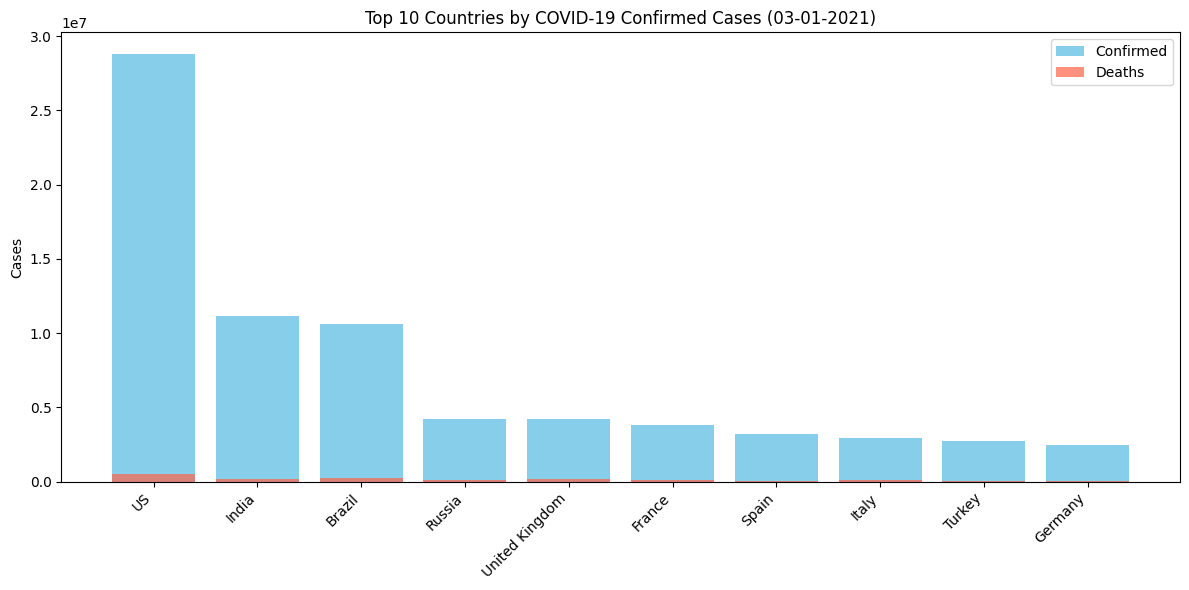

In [29]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 6))

# Plot total confirmed cases
plt.bar(top10_pd['Country_Region'], top10_pd['Total_Confirmed'], color='skyblue', label='Confirmed')
plt.bar(top10_pd['Country_Region'], top10_pd['Total_Deaths'], color='tomato', label='Deaths', alpha=0.7)

# Add labels and title
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cases')
plt.title('Top 10 Countries by COVID-19 Confirmed Cases (03-01-2021)')
plt.legend()
plt.tight_layout()
plt.show()

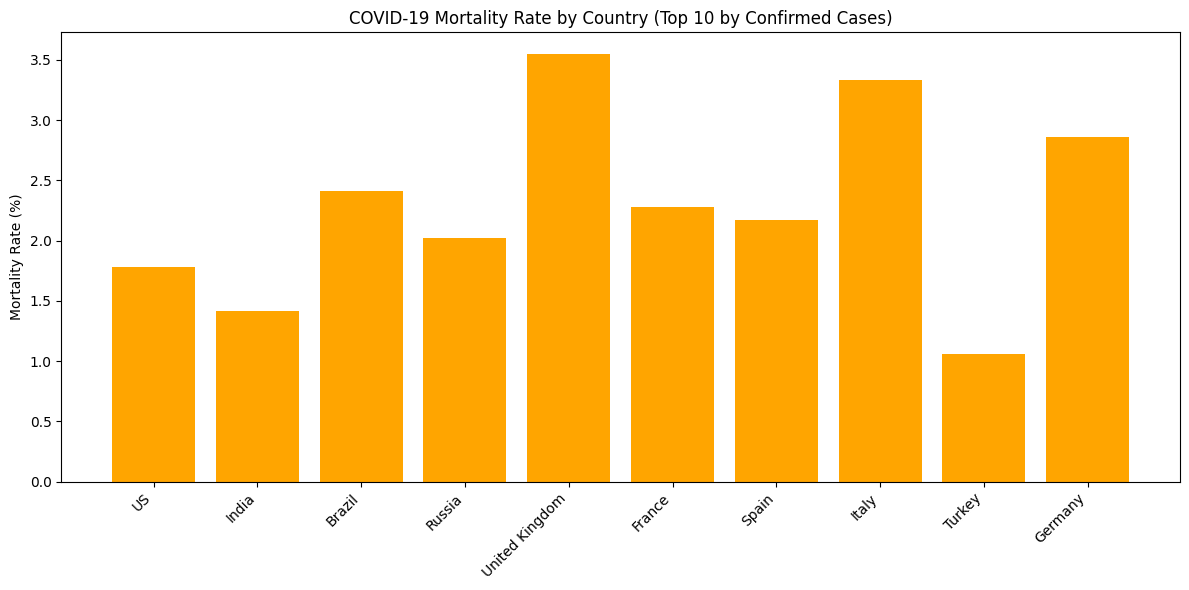

In [30]:
top10_pd["Mortality Rate (%)"] = (top10_pd["Total_Deaths"] / top10_pd["Total_Confirmed"]) * 100

plt.figure(figsize=(12, 6))
plt.bar(top10_pd['Country_Region'], top10_pd['Mortality Rate (%)'], color='orange')
plt.title('COVID-19 Mortality Rate by Country (Top 10 by Confirmed Cases)')
plt.ylabel('Mortality Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()